## Introduction

This notebook will use the data from the [data preparation notebook](https://github.com/charlier-su/education-inequality/blob/main/data_preparation.ipynb) to explore the relationship between socioeconomic factors and school performance, as measured by average student scores on the ACT exam, in order to understand the impact of educational opportunity inequality in U.S. high schools.

## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import itertools
from itertools import combinations
from math import comb

## Load clean data

The data imported by this notebook comes from two data sets. The primary data set is the EdGap data set from [EdGap.org](https://www.edgap.org/#5/37.875/-96.987). This data set from 2016 includes information about average ACT or SAT scores for schools and several socioeconomic characteristics of the school district. The secondary data set is basic information about each school from the [National Center for Education Statistics](https://nces.ed.gov/ccd/pubschuniv.asp).

The data preparation was documented in the [data preparation notebook](https://github.com/charlier-su/education-inequality/blob/main/data_preparation.ipynb). The prepared data frames are available as csv files in the GitHub repository as [clean_school_info_train.csv](https://github.com/charlier-su/education-inequality/blob/main/clean_school_info_train.csv) and [clean_school_info_test.csv](https://github.com/charlier-su/education-inequality/blob/main/clean_school_info_test.csv). Here, they are imported into the notebook:

In [ ]:
df_train = pd.read_csv('https://raw.githubusercontent.com/charlier-su/education-inequality/main/clean_school_info_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/charlier-su/education-inequality/main/clean_school_info_test.csv')

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5772 entries, 0 to 5771
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rate_unemployment  5772 non-null   float64
 1   percent_college    5772 non-null   float64
 2   percent_married    5772 non-null   float64
 3   median_income      5772 non-null   float64
 4   percent_lunch      5772 non-null   float64
 5   id                 5772 non-null   int64  
 6   region             5772 non-null   object 
 7   average_act        5772 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 360.9+ KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1443 entries, 0 to 1442
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rate_unemployment  1443 non-null   float64
 1   percent_college    1443 non-null   float64
 2   percent_married    1443 non-null   float64
 3   median_income      1443 non-null   float64
 4   percent_lunch      1443 non-null   float64
 5   id                 1443 non-null   int64  
 6   region             1443 non-null   object 
 7   average_act        1443 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 90.3+ KB


## Questions

* What factors contribute most to ACT score?
  * More specifically, what quantitative predictors are most effective for estimating ACT score?
* If certain socioeconomic factors are unhelpful for predicting ACT score, why might that be?
* Does region (i.e. area within the US) affect ACT score?

## Analysis

#### What factors contribute most to ACT score?
*More specifically, what quantitative predictors are most effective for estimating ACT score?*

The five quantitative predictors we have available are `median_income`, `percent_college`, `percent_lunch`,  `percent_married`, and `rate_unemployment`.

In [ ]:
all_predictors = ['median_income', 'percent_college', 'percent_lunch',  'percent_married', 'rate_unemployment']

A function is created to figure out how helpful a given set of predictors is for estimating ACT. The function works like this:
1. A model is created using the provided formula and the training data set, `df_train`.
2. The model is used to predict ACT scores within the test data set, `df_test`.
3. The mean squared error between the predicted values and actual values is calculated.

We understand a **lower** mean squared error generally means a **more effective** model.

For convenience, another function is also created that will generate a formula from an array of predictors and call the original function from there.

This function calculates the mean squared error (MSE) between the predicted ACT scores and the actual ACT scores for a given formula. We use MSE as a metric to evaluate the effectiveness of our models because it quantifies the average squared difference between the predicted and actual values. A lower MSE generally indicates a more accurate model, as it suggests that the model's predictions are closer to the true values. However, it's important to note that a model with a very low MSE might be overfitting the data, which means it would not generalize well to new, unseen data. In our analysis, we aim to


In [ ]:
def mse_from_formula(formula):
  model = smf.ols(formula=formula, data=df_train).fit()
  y_predict = model.predict(df_test)
  return mean_squared_error(y_predict, df_test['average_act'])

def mse_from_predictors(predictor_names):
  return mse_from_formula(f'average_act ~ {" + ".join(predictor_names)}')

Our number of predictors in a model, `k`, can range from one to five because we have five predictors to choose from. For each value of `k`, the effectiveness is tested for each possible combination of predictors.

In [ ]:
models = []
for k in range(1, 6):
  subset = combinations(all_predictors, k)
  for names in subset:
    mse = mse_from_predictors(names)
    models.append({
        'predictors': names,
        'mse': mse
    })

The best model is extracted from the models list.

In [ ]:
answer = min(models, key=lambda model: model['mse'])

best_predictors = answer['predictors']
best_mse = answer['mse']

print('predictors:', best_predictors)
print('mean squared error:', best_mse)

predictors: ('percent_college', 'percent_lunch', 'rate_unemployment')
mean squared error: 2.4044561309847174


The most effective model for predicting ACT scores includes three predictors: `percent_college`, `percent_lunch`, and `rate_unemployment`. This suggests that the percentage of adults with a college degree in the area, the rate of unemployment in the area, and the percentage of students using a free and reduced lunch program have the strongest influence on ACT scores among the examined factors.

The strong influence of `percent_lunch` on ACT scores shows the connection between the students' economic background and their academic performance. A higher percentage of students using free and reduced lunch programs could mean a higher percentage of economically disadvantaged students, which may be correlated with lower ACT scores.

The other two predictors, `percent_college` and `rate_unemployment`, reflect the overall socioeconomic status of the area surrounding the school. Areas with higher unemployment rates and lower percentages of college-educated adults might have fewer resources available to support education, potentially leading to lower ACT scores. This shows the importance of considering socioeconomic factors when analyzing and addressing educational disparities.

We can visually confirm the accuracy of the model by plotting the predicted scores with the actual scores in `df_test`:

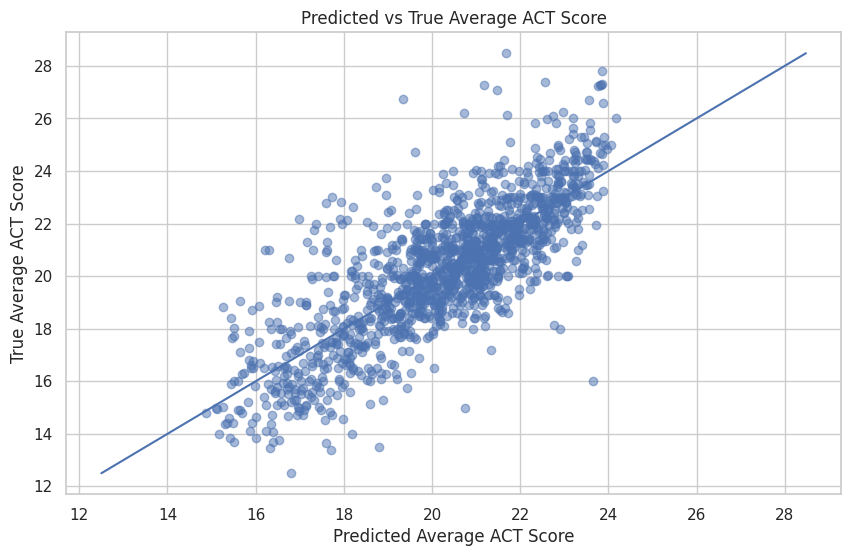

In [ ]:
formula = f'average_act ~ {" + ".join(best_predictors)}'
model = smf.ols(formula=formula, data=df_train).fit()
y_predict = model.predict(df_test)
y_actual = df_test['average_act']

plt.figure(figsize=(10,6))
plt.scatter(y_predict, y_actual, alpha=0.5)
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()])
plt.title('Predicted vs True Average ACT Score')
plt.xlabel('Predicted Average ACT Score')
plt.ylabel('True Average ACT Score')
plt.show()

The plotted points appear to follow the reference line nicely. A mean squared error of 2.4 means that the predictions are off by an average of about 1.5 points, which aligns with what we see on this plot.

#### If certain socioeconomic factors are unhelpful for predicting ACT score, why might that be?

The most effective model used `percent_college`, `percent_lunch`, and `rate_unemployment`. Its mean squared error can be compared against a model that uses all of the predictors:

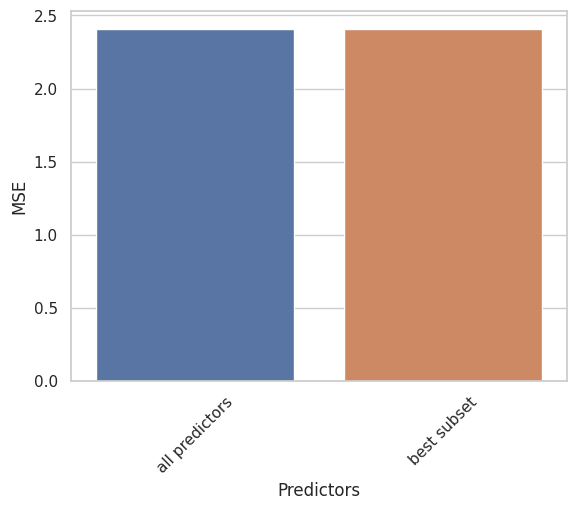

In [ ]:
sns.barplot(x='Predictors', y='MSE', data={
  'Predictors': ['all predictors', 'best subset'],
  'MSE': [mse_from_predictors(all_predictors), mse_from_predictors(best_predictors)]
})
plt.xticks(rotation=45)
plt.xlabel('Predictors')
plt.ylabel('MSE')
plt.show()

Adding `median_income` and `percent_married` did not improve the effectiveness of the model at all. A possible explanation for this is that both of these factors are measured from the statistics about the location of the school, rather than the population of the school itself.

This can be investigated further by looking at the mean squared error from models that use each factor individually:

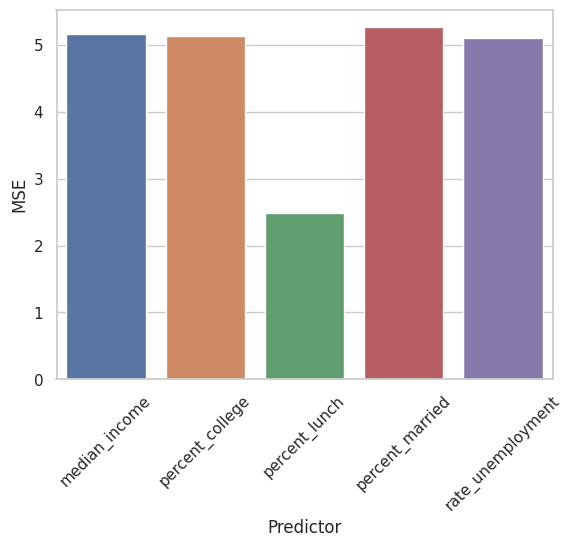

In [ ]:
sns.barplot(x='Predictor', y='MSE', data={
  'Predictor': all_predictors,
  'MSE': [mse_from_predictors([predictor]) for predictor in all_predictors]
})
plt.xlabel('Predictor')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.show()

`percent_lunch` has, by far, the closest association with ACT score. Notably, it is the only predictor we have that is directly related to the student body rather than households in the area. This reveals a limitation in the data we are working with: most of the data we have are about households associated with the location of the school rather than the population of the school, which seems to make a difference here. This problem is further demonstrated if we decompose the best predictors into separate models:

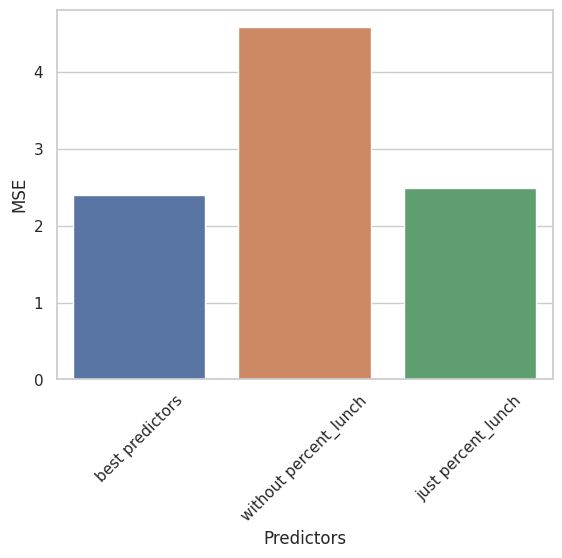

In [ ]:
sns.barplot(x='Predictors', y='MSE', data={
  'Predictors': [
    'best predictors',
    'without percent_lunch',
    'just percent_lunch'
  ],
  'MSE': [
    mse_from_predictors(best_predictors),
    mse_from_predictors(['percent_college', 'rate_unemployment']),
    mse_from_predictors(['percent_lunch'])
  ]
})
plt.xticks(rotation=45)
plt.xlabel('Predictors')
plt.ylabel('MSE')
plt.show()

The model that uses `percent_lunch` by itself is almost as effective as the best model. The model that uses the other predictors with `percent_lunch` removed performs poorly, in comparison. While `percent_college` and `rate_unemployment` do help the model, `percent_lunch` is doing the heavy lifting here. This association can be seen within the data itself by plotting `percent_lunch` with `average_act`:

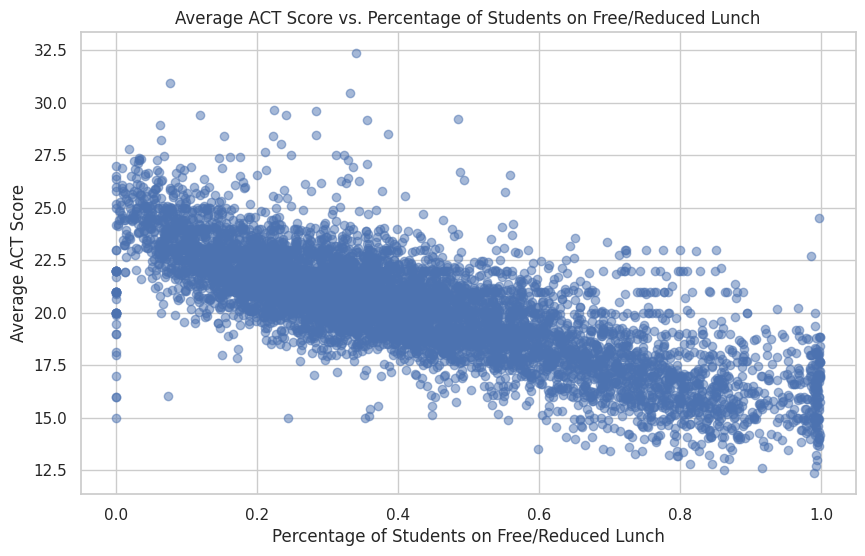

In [ ]:
plt.figure(figsize=(10,6))
df = pd.concat([df_train, df_test])
plt.scatter(df['percent_lunch'], df['average_act'], alpha=0.5)
plt.title('Average ACT Score vs. Percentage of Students on Free/Reduced Lunch')
plt.xlabel('Percentage of Students on Free/Reduced Lunch')
plt.ylabel('Average ACT Score')
plt.show()

The scatterplot reveals a clear negative correlation between the percentage of students on free/reduced lunch programs and average ACT scores, suggesting that economic disadvantage can contribute to lower academic performance. This supports our analysis which identified `percent_lunch` as a strong predictor of ACT scores.

#### Does region (i.e. area within the US) affect ACT score?


The mean squared error is calculated for three different linear regression models: one using `percent_lunch` as the sole predictor, another using both `percent_lunch` and the categorical variable `region`, and a third incorporating an interaction term between `percent_lunch` and `region`.

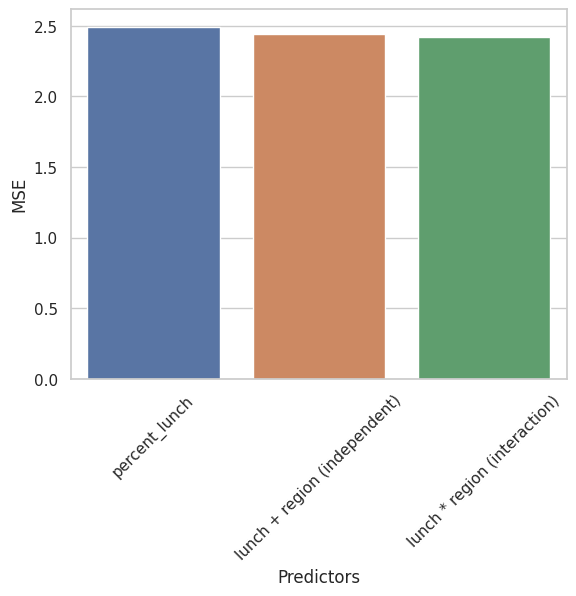

In [ ]:
sns.barplot(x='Predictors', y='MSE', data={
  'Predictors': [
    'percent_lunch',
    'lunch + region (independent)',
    'lunch * region (interaction)'
  ],
  'MSE': [
    mse_from_formula('average_act ~ percent_lunch'),
    mse_from_formula('average_act ~ percent_lunch + C(region)'),
    mse_from_formula('average_act ~ percent_lunch * C(region)')
  ]
})
plt.xticks(rotation=45)
plt.xlabel('Predictors')
plt.ylabel('MSE')
plt.show()

We see a slight improvement in our predictions when we add the categorical variable `region`, and another slight improvement when we incorporate the interaction term. This suggests that region does have some effect on ACT score, but there are some nuances to consier:

* The categories for the `region` variable were defined casually, mainly to explore any potential patterns in the data. These groupings were not based on any established criteria, but served as an initial attempt to examine regional influences. Further research might refine these categories or consider more established regional classifications.
* The data available for this analysis was incomplete, as it did not include schools from every state. This limitation means that we should be cautious about drawing definitive conclusions about the correlation we found with the `region` variable. The missing data may lead to an incomplete or biased representation of the regional patterns, and further research with a more comprehensive dataset would be necessary to validate the observed relationships.

## Conclusion

Our analysis revealed that a school's ACT score can be predicted within a range of 1-2 points *(i.e., with an MSE of 2.4)* based on socioeconomic factors. The strongest predictor among the examined factors was the proportion of students using free and reduced lunch programs, emphasizing the influence of students' economic background on their school performance. The percentage of adults with a college degree in the area and the rate of unemployment in the area were also significant predictors, reflecting the overall socioeconomic status of the school's surrounding community.

It is also important to recognize the limitations of this analysis, though. The data is primarily related to households in the school's vicinity rather than the student body itself, which may not accurately capture the socioeconomic conditions experienced by the students. Moreover, the data set did not include schools from every state, which could lead to an incomplete or biased representation of the regional patterns.

Future research could explore additional factors that might influence school performance, such as family income or parental education levels, to better understand the complex relationships between socioeconomic factors and educational outcomes. Additionally, a more comprehensive data set including schools from all states would be valuable for validating the observed patterns and strengthening the conclusions.

